In [1]:
#imports and data input

import matplotlib.pyplot as plt
import _pickle as cPickle
import pickle
import gzip 
import numpy as np
import sys
import time
from scipy.special import expit

f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f,encoding='latin1')
f.close()

In [49]:
#these are just various mathematical tools needed for the NN

def identity(x):
    return x

def identityPrime(x):
    return np.ones(len(x))

def sigmoidPrime(x):
    return expit(x)*(1-expit(x)) #use expit to prevent overflow with large values

def sigmoid(x):
    return expit(x) #admittedly this is a little unnecessary but I think it makes sense to have 
    #sigmoid and sigmoidPrime instead of expit and sigmoidPrime

def relu(x):
    z = x * (x>0)
    return z

def reluprime(x):
    return (x>0).astype(x.dtype)

def softMax(x):
    z = np.exp(x)
    return z/sum(z)

def softMaxPrime(x):
    z = np.exp(x)
    c = sum(z)
    for i in range(len(z)):
        z[i] = (c-z[i])*z[i]/(c*c)
    return z

def logLoss(x, target):
    loss = 0
    for i in range(len(x)):
        loss += target[i]*np.log(x[i])+(1-target[i])*np.log(1-x[i])
    return (-1.0/len(x))*loss
    
def logLossPrime(x, target):
    grad = np.zeros(len(x))
    for i in range(len(x)):
        grad[i]=(-1.0/len(x))*(target[i]/x[i]-(1-target[i])/(1-x[i]))
    return grad

def MSE(x, target):
    a = x-target
    return np.dot(a,a)

def MSEPrime(x, target):
    return 2*(x-target)

def crossEntropy(output, target):
    return -np.sum(target*np.log(output))

def crossEntropyPrime(output, target):
    return -target/output

def softMaxCross(x, target):
    return crossEntropy(softMax(x), target)

def softMaxCrossPrime(x, target):
    return softMax(x)-target

def trainingGraph(trainingData):
    x_range = trainingData[1][0]
    batch_costs = trainingData[0]
    total_costs = trainingData[1][1]
    accuracies = np.array(trainingData[2][1])
    plt.plot(batch_costs, 'rx')
    plt.ylabel("batch cost")
    plt.xlabel("iteration")
    plt.show()
    plt.plot(x_range, total_costs, 'ro')
    plt.ylabel("total cost")
    plt.xlabel("iteration")
    plt.show()
    plt.plot(x_range, 100.0*(1.0-accuracies), 'bo')
    plt.ylabel("total error percentage")
    plt.xlabel("iteration")
    plt.show()    

class Neural_Network:
    defaultSize = 16 #default number of neurons in hidden layers if no shape list given
    inputChecks = True #this will change whether inputs that match the MNIST format are given
    #can be turned off to allow for debugging on smaller examples
    
    #activation must be an activation function that works for vectors 
    #and activation prime is its derivative. costFunction is a cost function for a vector representing an output layer
    #and the target vector. costDeriv is its derivative with respect to the vector of activations.
    #shape is list of integers where shape[i] = the number of neurons in ith layer
    #layers is an integer describing the number of layers, lastAct is an optional change so that on the last layer
    #you can have a different activation function
    #shape and layers are optional. if both are given the shape list will be followed, if neither are given
    #it will use the default value for layers and make all hidden layers have defaultSize many neurons
    #lastAct and lastActPrime are the activation function and its derivative for the last layer. if left blank
    #will default to the given activation and activationPrime
    def __init__(self, activation, activationPrime, costFunction, costDeriv, shape = None, layers = 4, 
                 lastAct = None, lastActPrime = None):
        if layers<2:
            raise NameError("Too few layers. Need an input layer and an output layer.")
        if Neural_Network.inputChecks and (shape[0] != 28**2 or shape[len(shape)-1] != 10):
            raise NameError("Improper input or output layer size. \
                            Must be 28^2 input neurons and 10 output neurons to work with MNIST.")
        if shape==None:
            shape = [28**2] + [defaultSize for i in range(layers-2)] + [10]
        self.activation = activation
        self.activationPrime = activationPrime
        self.shape = shape
        self.costFunction = costFunction
        self.costDeriv = costDeriv
        self.weights = Neural_Network.constructWeights(shape) 
        #weights[i] is the weights going into layer i
        self.bias = Neural_Network.constructBias(shape)
        #bias[i] is the bias on layer i
        if lastAct == None:
            self.lastAct = activation
            self.lastActPrime = activationPrime
        else:
            self.lastAct = lastAct
            self.lastActPrime = lastActPrime
        self.activations = []
        self.zs = []
        
    #returns a list of matrices of weights. weights[i] is the set of weights going into ith layer
    #weights[i][j][k] represents the weight going from the kth neuron in layer i-1 to jth neuron in layer i 
    def constructWeights(shape):
        weights = [None]
        for i in range(len(shape)-1): 
            weights.append(np.random.uniform(-0.1,0.1,shape[i]*shape[i+1]).reshape((shape[i+1],shape[i])))
        return weights
    
    #returns a list of vectors of biases. bias[i] is the set of biases on the ith layer
    #bias[i][j] is the bias in the ith layer on the jth neuron
    def constructBias(shape):
        bias = [None]
        for i in range(1,len(shape)): 
            bias.append(np.random.uniform(-0.1,0.1,shape[i]))
        return bias
    
    #performs forward propagation on the input x with the current weights and biases
    #using activation function from the constructor returns the activations on the last layer 
    #updates the zs and activations attributes
    def forwardProp(self, x):
        if Neural_Network.inputChecks and len(x) != 28**2:
            raise NameError("improper input")
        prevAct = x
        act = []
        self.activations = []
        self.zs = []
        self.activations.append(prevAct)
        for i in range(1,len(self.shape)-1): #each layer except for last
            z = np.dot(self.weights[i], prevAct) + self.bias[i]
            act = self.activation(z)
            self.activations.append(act)
            self.zs.append(z)
            prevAct = act
        i = len(self.shape)-1    
        z = np.dot(self.weights[i], prevAct) + self.bias[i]
        act = self.lastAct(z)
        self.activations.append(act)
        self.zs.append(z)
        prevAct = act
        return act
    
    #returns the total cost for the neural network on all datapoints in data
    #using cost function costFunc for each point. returns cost as a scalar
    def totalCost(self, data, costFunc):
        images = data[0]
        labels = data[1]
        if Neural_Network.inputChecks and len(images) != len(labels):
            raise NameError("improper input")
        target = np.zeros(10)
        cost = 0 
        for i in range(len(images)):
            target[labels[i]] = 1
            out = self.forwardProp(images[i])
            cost += costFunc(out, target)
            target[labels[i]] = 0
        return cost
        
    #returns the classification as a scalar based on the outputActivations
    #picks the index with highest activation
    def classification(outputActivations):
        maximum = -1
        index = -1
        for i in range(len(outputActivations)):
            if outputActivations[i] >= maximum:
                index = i
                maximum = outputActivations[i]
        return index
     
    #randomly initializes all weights and biases    
    def randomInitialization(self):
        self.weights = Neural_Network.constructWeights(self.shape) 
        self.bias = Neural_Network.constructBias(self.shape)
    
    #using backProp this will perform gradient descent from the current initialization of the weights
    #and biases on the given data. data in form touple of array of images and array of labels
    #will stop after iterations many iterations. returns a touple of the best weights and biases
    #and a list of the costs over time. will update the weights and biases in the neural network
    #suppressPrint will not print anything between steps if set to true
    #costInterval determines how often the cost will be re-computed, saved, printed (if suppressPrint is false)
    #and how often the best weights and biases are saved. when set to 1 it occurs on every step
    def gradientDescent(self, data, iterations, learningRate, suppressPrint = False, costInterval = 1):
        return self.stochasticGradientDescent(data, len(data[0]), iterations, learningRate, suppressPrint, costInterval)
    
    #will apply the gradient with stepSize where the gradient is in form 
    #given by the backProp function
    def applyGradient(self, gradient, stepSize):
        for i in range(1, len(gradient[0])): #for each matrix in the weight update, 
            #first value is None for convenience in indexing
            self.weights[i] -= stepSize * gradient[0][i]
        for i in range(1, len(gradient[1])): #for each vector in the bias update
            self.bias[i] -= stepSize * gradient[1][i]
    
    #computes the correct and incorrect number of classified data points on data
    #prints the number correct, number incorrect, percent correct, and percent incorrect
    #returns a touple of the number correct and total number of data points
    def validation(self, data, suppressPrint = False):
        images = data[0]
        labels = data[1]
        if len(images) != len(labels):
            raise NameError("improper input")
        correct = 0 
        wrong = 0
        for i in range(len(images)):
            if (Neural_Network.classification(self.forwardProp(images[i]))) == labels[i]:
                correct += 1
            else:
                wrong += 1
        if not suppressPrint:
            print("correct: ", correct)
            print("wrong: ", wrong)
            print("accuracy:", 100.0*correct/len(images), "%")
            print("error:", 100.0*wrong/len(images), "%")
        return (correct, len(images))
    
    #chooses a random batch of size batchSize from images and labels
    #note it does not replace when sampling
    def randomBatch(images, labels, batchSize):
        indices = np.random.choice(len(images), batchSize, replace = False)
        #if you set replace to True this will break the gradientDescent function
        imageBatch = []
        labelBatch = []
        for i in range(len(indices)):
            imageBatch.append(images[indices[i]])
            labelBatch.append(labels[indices[i]])
        return (imageBatch, labelBatch)
        
    #using backProp this will perform stoachastic gradient descent from the current initialization of the weights
    #and biases on the given data. will choose batchSize many samples from data 
    #data in form touple of array of images and array of labels
    #will stop after iterations many iterations. returns a touple of the best weights and biases
    #and a list of the costs over time. will update the weights and biases in the neural network
    #suppressPrint will not print anything between steps if set to true
    #costInterval determines how often the cost will be re-computed, saved, printed (if suppressPrint is false)
    #and how often the best weights and biases are saved. when set to 1 it occurs on every step
    def stochasticGradientDescent(self, data, batchSize, iterations, learningRate, suppressPrint = False, costInterval = 5):
        start = time.time()
        bestCost = sys.maxsize
        bestWandB = []
        total_costs = []
        batch_costs = []
        accuracies = []
        images = data[0]
        labels = data[1]
        for j in range(iterations):
            imageSet, labelSet = Neural_Network.randomBatch(images, labels, batchSize)
            target = np.zeros(10)
            gradients = []
            cost = 0
            for i in range(len(imageSet)):
                target[labelSet[i]] = 1
                output = self.forwardProp(imageSet[i])
                gradients.append(self.backProp(target))
                cost += self.costFunction(output, target)
                target[labelSet[i]] = 0
            batch_costs.append(cost)
            self.applyGradient(self.averageGradient(gradients), learningRate)
            if j % costInterval == 0: #performs this many gradient steps before re-computing the cost for all examples
                #this is somewhat of a hyper-parameter. Higher number = faster runtime but less training data, 
                #less info when it is running about how it is doing, and fewer opportunities to save the best configuration
                cost = self.totalCost(data, self.costFunction)
                total_costs.append(cost)
                a = self.validation(data, suppressPrint)
                accuracies.append(a[0]/a[1])
                if not suppressPrint:
                    print(cost)
                if cost <= bestCost:#this saves the best configuration so far but only on steps when the cost is computed
                    bestCost = cost
                    bestWandB = (self.weights, self.bias)
        x_range = [costInterval*i for i in range(len(total_costs))]#needed for graphing for correct # of iterations
        trainingData = (batch_costs, (x_range, total_costs), (x_range, accuracies))
        end = time.time()
        length = end - start
        unit = "seconds."
        if length > 3600:
            length /= 3600
            unit = "hours."
        elif length > 60:
            length /= 60
            unit = "minutes."
        print(iterations, "iterations took", length, unit)
        return (bestWandB, trainingData)
    
    #given a list of touples of the gradient in the form given by backProp
    #will return the average gradient
    def averageGradient(self, gradients):
        averageGrad = (Neural_Network.constructWeights(self.shape), Neural_Network.constructBias(self.shape))
        for i in range(len(averageGrad)): #weights then biases
            for j in range(len(gradients)): #grad from each sample
                for k in range(1, len(gradients[j][i])): #grad for each matrix
                    averageGrad[i][k] += gradients[j][i][k]
            for k in range(1,len(averageGrad[i])):#done at end to prevent rounding small numbers to zero
                averageGrad[i][k] /= len(gradients) #if overflow is a problem then divide at each step
        return averageGrad
    
    #this will return the gradient of the cost on the single target
    #the form is a touple with the weights and then the biases
    #in the same format as the weights and biases attributes for the Neural_Network class
    def backProp(self, target):
        if Neural_Network.inputChecks and len(target) != 10:
            raise NameError("improper input")
        biasGrad = [None for _ in range(len(self.shape))]
        weightGrad = [None for _ in range(len(self.shape))]
        delta = self.costDeriv(self.activations[-1], target) * self.lastActPrime(self.zs[-1])
        biasGrad[-1] = delta
        weightGrad[-1] = np.tile(np.array([delta]).transpose(), (1,self.shape[-2]))*np.tile(np.array(self.activations[-2]),(self.shape[-1],1))
        #this line (and the version of it below can be a little confusing, see readme)
        for l in range(2, len(self.shape)):
            z = self.zs[-l]
            actDeriv = self.activationPrime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * actDeriv
            biasGrad[-l] = delta
            weightGrad[-l] = np.tile(np.array([delta]).transpose(), (1,self.shape[-l-1]))*np.tile(np.array(self.activations[-l-1]),(self.shape[-l],1))
        return (weightGrad, biasGrad)
    

The line right before the for loop in ```backProp()``` is a little confusing so I'll explain. $\frac{\partial C}{\partial W^{l}_{j,k}} = a^{l-1}_{k} \Delta^{l}_{j}$ where $C$ is the cost and $W^{l}_{j,k}$ is the weight going from the $k$th neuron in the $l-1$th layer to the $j$th neuron in the $l$th layer, $a^{l-1}_{k}$ is the activation on the $k$th neuron in the $l-1$th layer, and $\Delta^{l}_{j}$ is the derivative of the cost with respect to the $j$th component of $z^{l}$. 

If you've never seen this before, it can be confusing so draw out a simple NN with very few neurons and write out the gradient of the weight matrix. You will notice that if you make a matrix with the same dimensions as $W^{l}$ where the columns are the vector $\Delta^{l}$ and the same dimension matrix where the rows are the row vector $(a^{l-1})^{T}$ and do element-wise multiplication (not matrix multiplication) of these matrices, then the resulting matrix is the gradient of the cost with respect to the weight matrix $W^{l}$.

If you're more comfortable with index notation you can also just see that in the gradient matrix of the cost with respect to the weight $W^{l}$ weights with the same row have the same $\Delta$ value being multiplied. Similarly weights with the same column have the same $a^{l-1}$ value being multiplied.

```np.tile``` allows you to create matrices from repeating column or row vectors. The [NumPy documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.tile.html) explains it much better than I can. Thus in this line I use ```np.tile``` to create a matrix where the columns are the vector $\Delta^{l}$ and a matrix where the rows are $(a^{l-1})^{T}$ and then perform element-wise multiplication. 

In [50]:

shallowModel = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 100, 10])
deepModel = Neural_Network(relu, reluPrime, softMaxCross, softMaxCrossPrime, shape = [28**2, 300, 100, 10])

with open('training_data.pickle', 'rb') as handle: #load previously trained models
    lastData = pickle.load(handle)
    
shallowModel.weights, shallowModel.bias  = lastData["a"]
deepModel.weights, deepModel.bias = lastData["b"]

#accuracy results
shallowModel.validation(valid_set)
deepModel.validation(valid_set)

correct:  9621
wrong:  379
accuracy: 96.21 %
error: 3.79 %
correct:  9703
wrong:  297
accuracy: 97.03 %
error: 2.97 %


(9703, 10000)

2000 iterations took 39.394722100098924 minutes.


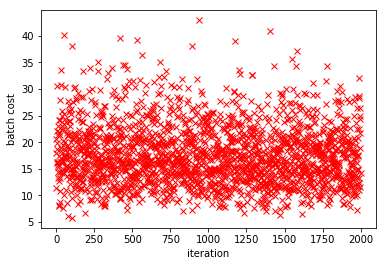

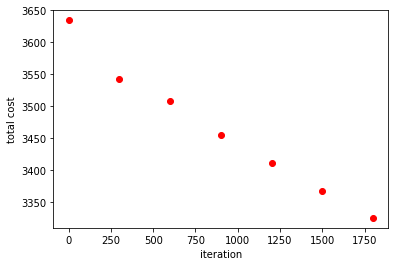

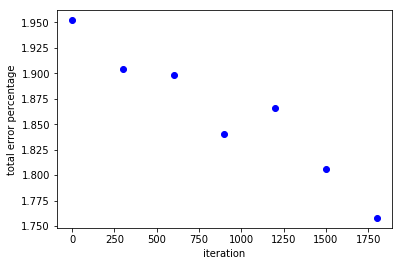

correct:  9702
wrong:  298
accuracy: 97.02 %
error: 2.98 %


(9702, 10000)

In [51]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 2000, 0.0105, suppressPrint = True, costInterval =300)
trainingGraph(trainData)
deepModel.validation(valid_set)

24000 iterations took 6.830996269716157 hours.


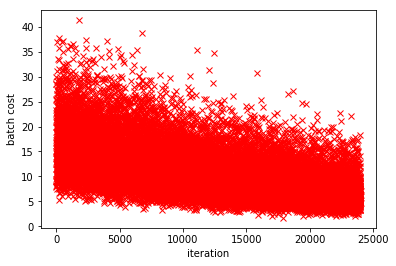

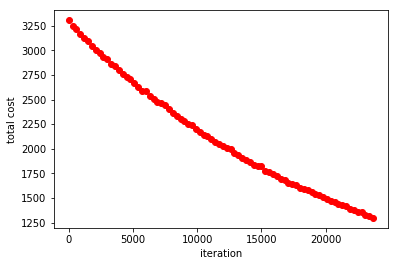

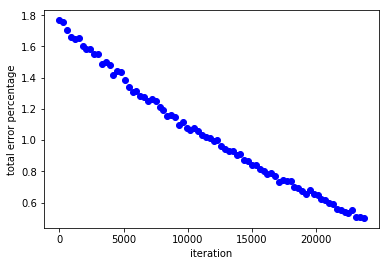

correct:  9770
wrong:  230
accuracy: 97.7 %
error: 2.3 %


(9770, 10000)

In [54]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 24000, 0.0105, suppressPrint = True, costInterval = 300)
trainingGraph(trainData)
deepModel.validation(valid_set)

In [55]:
deepModel.validation(train_set)

correct:  49735
wrong:  265
accuracy: 99.47 %
error: 0.53 %


(49735, 50000)

In [56]:
deepModel.validation(test_set)

correct:  9742
wrong:  258
accuracy: 97.42 %
error: 2.58 %


(9742, 10000)

3000 iterations took 1.9240582555532455 hours.


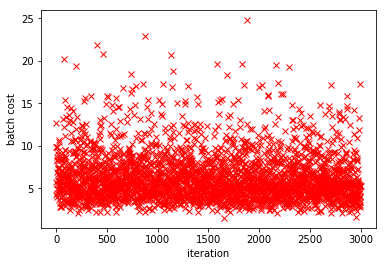

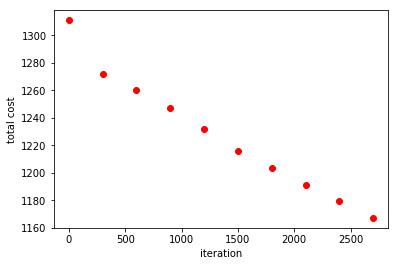

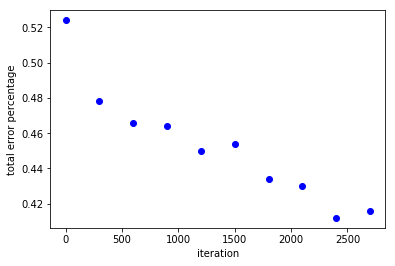

correct:  9764
wrong:  236
accuracy: 97.64 %
error: 2.36 %


(9764, 10000)

In [57]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 3000, 0.0105, suppressPrint = True, costInterval = 300)
trainingGraph(trainData)
deepModel.validation(valid_set)

In [58]:
deepModel.validation(test_set)

correct:  9754
wrong:  246
accuracy: 97.54 %
error: 2.46 %


(9754, 10000)

In [59]:
deepModel.validation(train_set)

correct:  49795
wrong:  205
accuracy: 99.59 %
error: 0.41 %


(49795, 50000)

1000 iterations took 19.653575082619984 minutes.


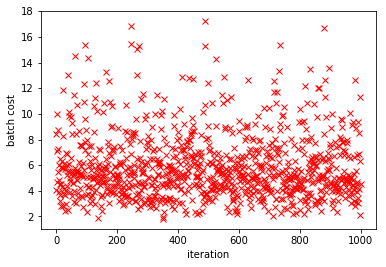

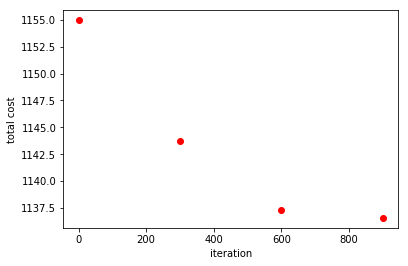

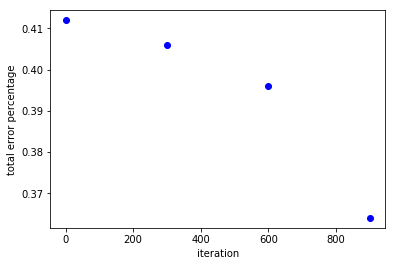

correct:  9774
wrong:  226
accuracy: 97.74 %
error: 2.26 %


(9774, 10000)

In [60]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 1000, 0.0105, suppressPrint = True, costInterval = 300)
trainingGraph(trainData)
deepModel.validation(valid_set)

In [61]:
deepModel.validation(test_set)

correct:  9758
wrong:  242
accuracy: 97.58 %
error: 2.42 %


(9758, 10000)

In [62]:
deepModel.validation(train_set)

correct:  49815
wrong:  185
accuracy: 99.63 %
error: 0.37 %


(49815, 50000)

1000 iterations took 18.768052128950753 minutes.


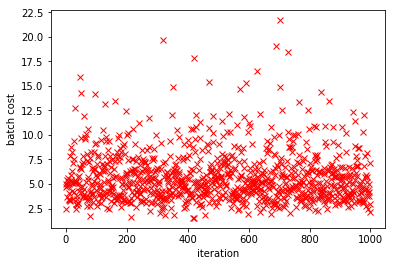

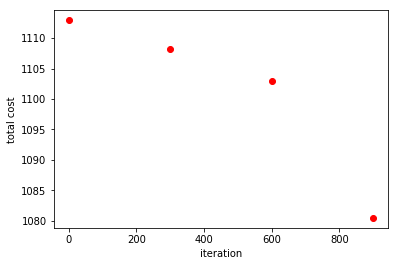

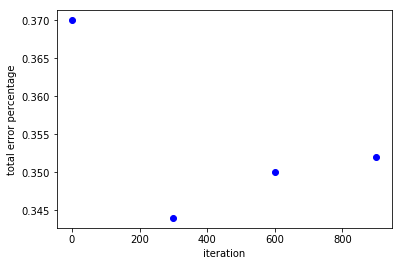

correct:  9765
wrong:  235
accuracy: 97.65 %
error: 2.35 %


(9765, 10000)

In [63]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 1000, 0.0105, suppressPrint = True, costInterval = 300)
trainingGraph(trainData)
deepModel.validation(valid_set)

In [64]:
deepModel.validation(test_set)

correct:  9759
wrong:  241
accuracy: 97.59 %
error: 2.41 %


(9759, 10000)

3000 iterations took 58.279641469319664 minutes.


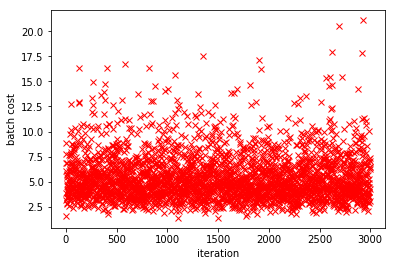

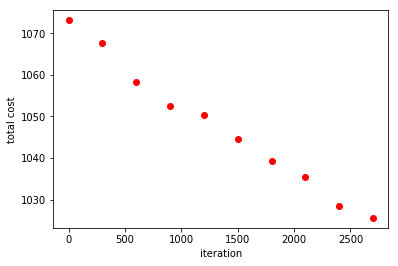

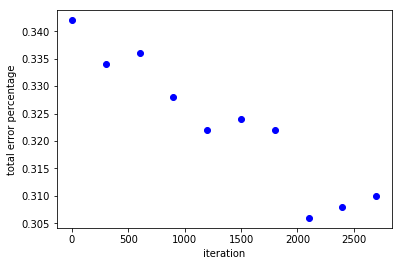

correct:  9777
wrong:  223
accuracy: 97.77 %
error: 2.23 %


(9777, 10000)

In [65]:
wb, trainData = deepModel.stochasticGradientDescent(train_set, 259, 3000, 0.005, suppressPrint = True, costInterval = 300)
trainingGraph(trainData)
deepModel.validation(valid_set)

In [66]:
deepModel.validation(test_set)

correct:  9758
wrong:  242
accuracy: 97.58 %
error: 2.42 %


(9758, 10000)

30000 iterations took 3.319467675222291 hours.


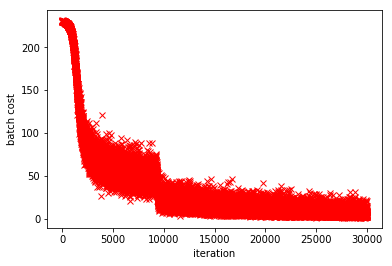

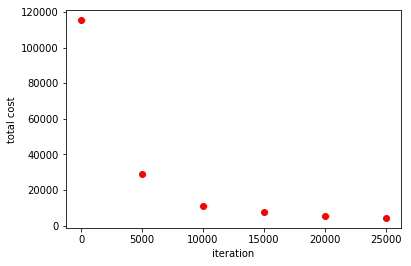

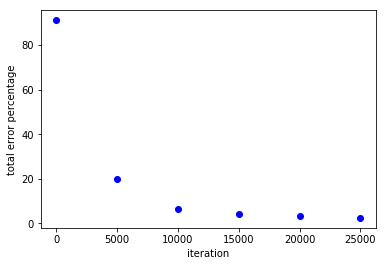

correct:  9694
wrong:  306
accuracy: 96.94 %
error: 3.06 %


(9694, 10000)

In [67]:
deepestModel = Neural_Network(relu, reluprime, softMaxCross, softMaxCrossPrime, shape=[28**2, 300, 100, 50, 10])
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 100, 30000, 0.007, suppressPrint = True, costInterval = 5000)
trainingGraph(trainData)
deepestModel.validation(valid_set)

In [70]:
deepestModel.validation(train_set)

correct:  49021
wrong:  979
accuracy: 98.042 %
error: 1.958 %


(49021, 50000)

10000 iterations took 1.2122580291165246 hours.


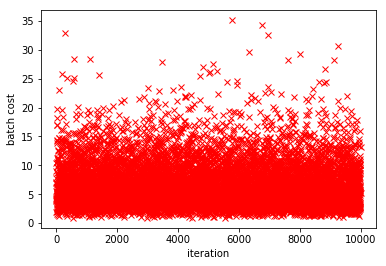

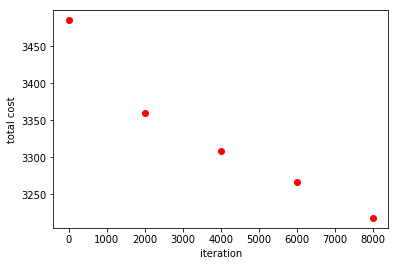

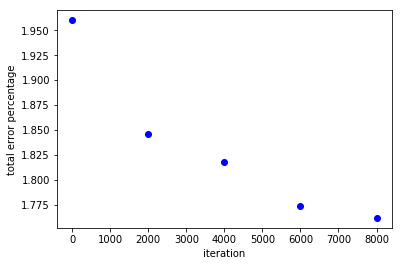

correct:  9692
wrong:  308
accuracy: 96.92 %
error: 3.08 %
correct:  9703
wrong:  297
accuracy: 97.03 %
error: 2.97 %


(9703, 10000)

In [71]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 100, 10000, 0.001, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)

In [72]:
deepestModel.validation(train_set)

correct:  49137
wrong:  863
accuracy: 98.274 %
error: 1.726 %


(49137, 50000)

1000 iterations took 3.574827229976654 minutes.


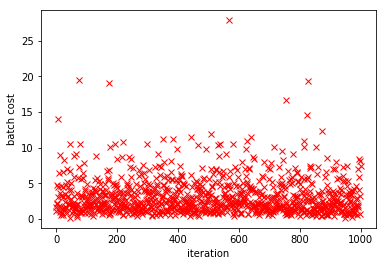

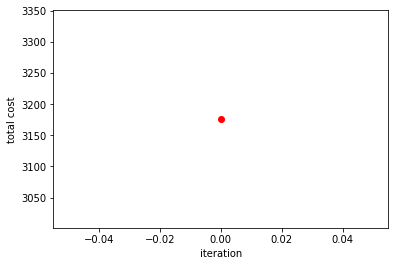

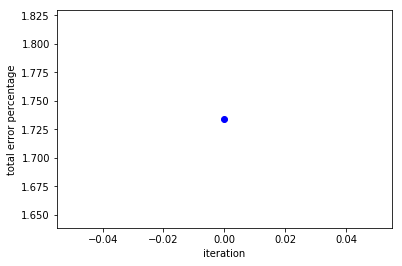

correct:  9696
wrong:  304
accuracy: 96.96 %
error: 3.04 %
correct:  9700
wrong:  300
accuracy: 97.0 %
error: 3.0 %


(9700, 10000)

In [73]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 50, 1000, 0.001, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)

In [74]:
deepestModel.validation(train_set)

correct:  49129
wrong:  871
accuracy: 98.258 %
error: 1.742 %


(49129, 50000)

1000 iterations took 34.78067543506622 minutes.


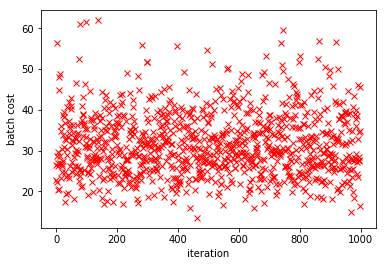

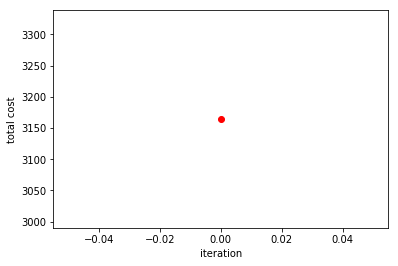

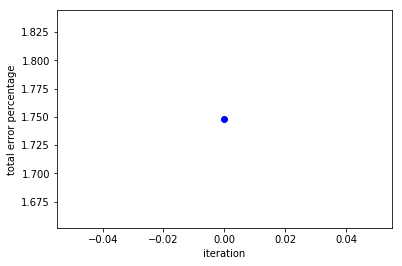

correct:  9697
wrong:  303
accuracy: 96.97 %
error: 3.03 %
correct:  9702
wrong:  298
accuracy: 97.02 %
error: 2.98 %


(9702, 10000)

In [75]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 500, 1000, 0.001, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)

correct:  49145
wrong:  855
accuracy: 98.29 %
error: 1.71 %


(49145, 50000)

2000 iterations took 1.6286212199926375 hours.


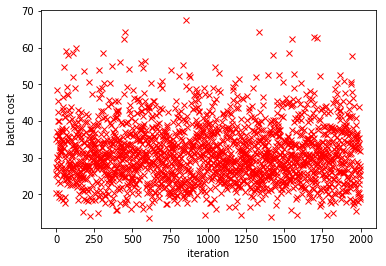

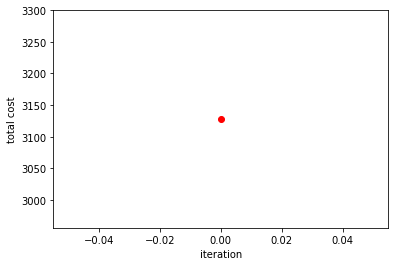

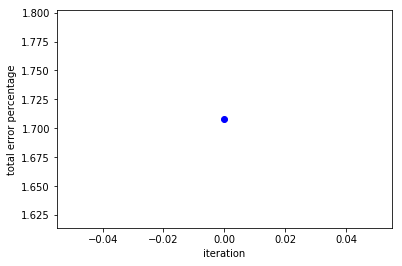

correct:  9699
wrong:  301
accuracy: 96.99 %
error: 3.01 %
correct:  9706
wrong:  294
accuracy: 97.06 %
error: 2.94 %
correct:  49153
wrong:  847
accuracy: 98.306 %
error: 1.694 %


(49153, 50000)

In [77]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 500, 2000, 0.001, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)
deepestModel.validation(train_set)

18000 iterations took 10.185450370775328 hours.


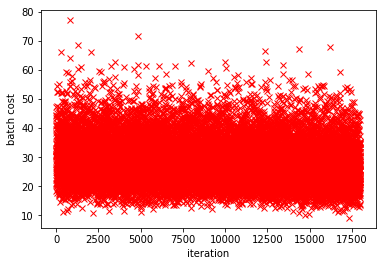

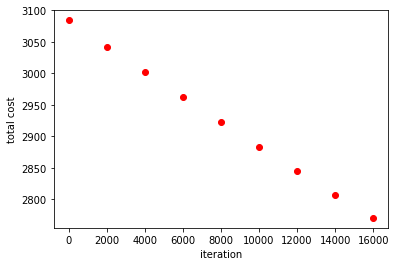

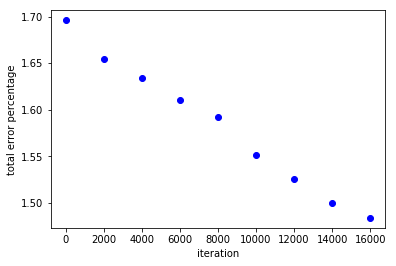

correct:  9707
wrong:  293
accuracy: 97.07 %
error: 2.93 %
correct:  9716
wrong:  284
accuracy: 97.16 %
error: 2.84 %
correct:  49269
wrong:  731
accuracy: 98.538 %
error: 1.462 %


(49269, 50000)

In [78]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 500, 18000, 0.001, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)
deepestModel.validation(train_set)

1000 iterations took 43.72863641579946 minutes.


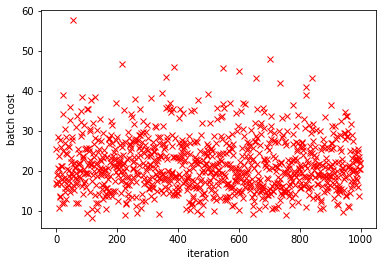

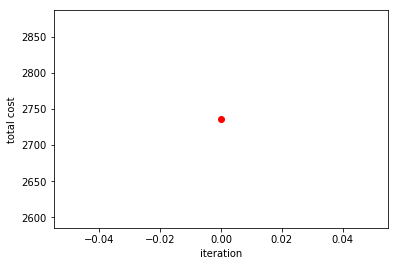

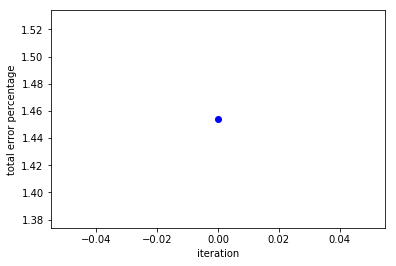

correct:  9706
wrong:  294
accuracy: 97.06 %
error: 2.94 %
correct:  9716
wrong:  284
accuracy: 97.16 %
error: 2.84 %
correct:  49288
wrong:  712
accuracy: 98.576 %
error: 1.424 %


(49288, 50000)

In [79]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 400, 1000, 0.004, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)
deepestModel.validation(train_set)

10000 iterations took 4.188830666674508 hours.


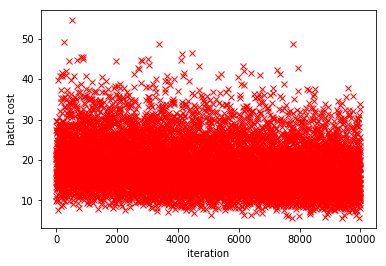

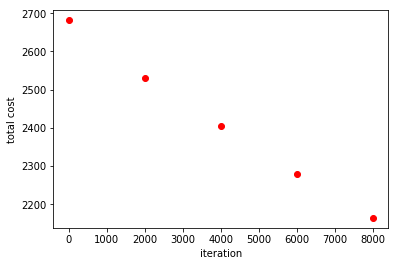

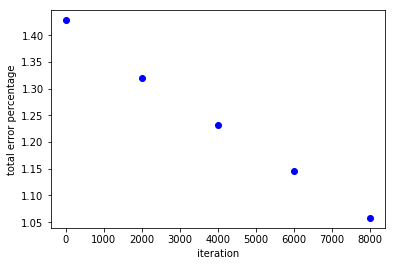

correct:  9731
wrong:  269
accuracy: 97.31 %
error: 2.69 %
correct:  9736
wrong:  264
accuracy: 97.36 %
error: 2.64 %
correct:  49501
wrong:  499
accuracy: 99.002 %
error: 0.998 %


(49501, 50000)

In [80]:
wb, trainData = deepestModel.stochasticGradientDescent(train_set, 400, 10000, 0.004, suppressPrint = True, costInterval = 2000)
trainingGraph(trainData)
deepestModel.validation(valid_set)
deepestModel.validation(test_set)
deepestModel.validation(train_set)

In [ ]:
1